In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
kidney_df_pd = pd.read_csv(r'.\Kidney disease.csv')
kidney_df = np.asarray(kidney_df_pd)
wine_df_pd = pd.read_csv(r'.\white_wine_quality.csv')
wine_df = np.asarray(wine_df_pd)

In [3]:
kidney_df_pd.columns = ['pregnancy', 'glucose', 'blood_pressure', 'heart rate', 
              'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function', 'age', 'result']
wine_df_pd.columns = ['alcohol', 'malic_acid', 'ash', 'alkalinity_of_ash', 
              'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'hue', 'class']

In [4]:
print(kidney_df_pd.keys())
print(wine_df_pd.keys())

Index(['pregnancy', 'glucose', 'blood_pressure', 'heart rate',
       'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function', 'age',
       'result'],
      dtype='object')
Index(['alcohol', 'malic_acid', 'ash', 'alkalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'hue', 'class'],
      dtype='object')


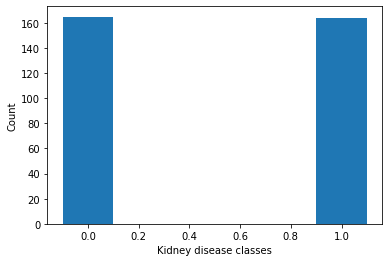

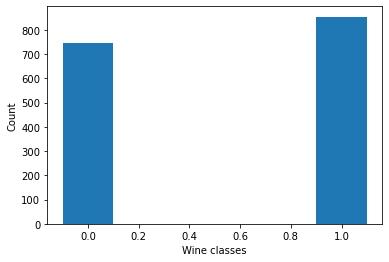

In [5]:
# the classes distribution.
plt.hist(kidney_df[:,-1], bins =[-0.1, 0.1, 0.9, 1.1])
plt.xlabel('Kidney disease classes')
plt.ylabel('Count')
plt.show()

plt.hist(wine_df[:,-1], bins =[-0.1, 0.1, 0.9, 1.1])
plt.xlabel('Wine classes')
plt.ylabel('Count')
plt.show()

In [6]:
labels_k = ['pregnancy', 'glucose', 'blood_pressure', 'heart rate', 
              'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']
labels_w = ['alcohol', 'malic_acid', 'ash', 'alkalinity_of_ash', 
              'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'hue']

In [7]:
class0_k = kidney_df[kidney_df[:,9] == 0]
class1_k = kidney_df[kidney_df[:,9] == 1]
class0_w = wine_df[wine_df[:,10] == 0]
class1_w = wine_df[wine_df[:,10] == 1]

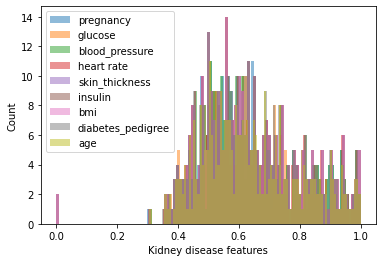

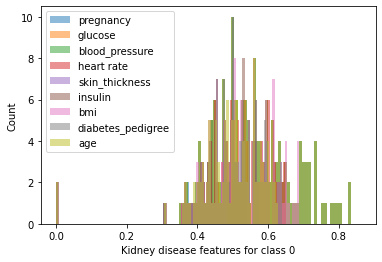

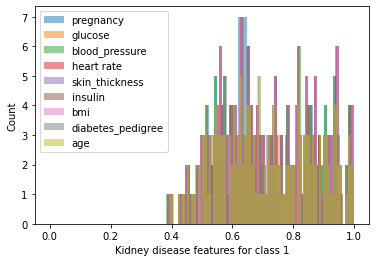

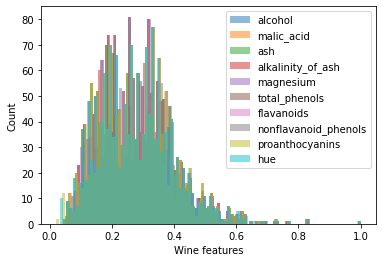

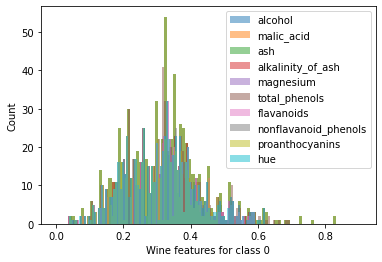

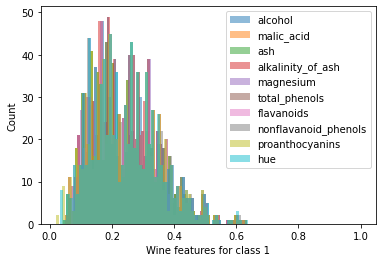

In [8]:
for i in range(len(kidney_df[0])-1):
  bins = np.linspace(min(kidney_df[i,:]), max(kidney_df[i,:]), 100)
  plt.hist(kidney_df[:,1], bins, alpha = 0.5, label = (labels_k[i]))
  plt.xlabel('Kidney disease features')
  plt.ylabel('Count')
  plt.legend(loc='upper left')
plt.show()

for i in range(len(class0_k[0])-1):
  bins = np.linspace(min(class0_k[i,:]), max(class0_k[i,:]), 100)
  plt.hist(class0_k[:,1], bins, alpha = 0.5, label = (labels_k[i]))
  plt.xlabel('Kidney disease features for class 0')
  plt.ylabel('Count')
  plt.legend(loc='upper left')
plt.show()

for i in range(len(class1_k[0])-1):
  bins = np.linspace(min(class1_k[i,:]), max(class1_k[i,:]), 100)
  plt.hist(class1_k[:,1], bins, alpha = 0.5, label = (labels_k[i]))
  plt.xlabel('Kidney disease features for class 1')
  plt.ylabel('Count')
  plt.legend(loc='upper left')
plt.show()


for i in range(len(wine_df[0])-1):
  bins = np.linspace(min(wine_df[i,:]), max(wine_df[i,:]), 100)                 #100 sample for each feature divided equaly between maximum and minimum values for each feature 
  plt.hist(wine_df[:,1], bins, alpha = 0.5, label = (labels_w[i]))
  plt.xlabel('Wine features')
  plt.ylabel('Count')
  plt.legend(loc='upper right')
plt.show()

for i in range(len(class0_w[0])-1):
  bins = np.linspace(min(class0_w[i,:]), max(class0_w[i,:]), 100)                 #100 sample for each feature divided equaly between maximum and minimum values for each feature 
  plt.hist(class0_w[:,1], bins, alpha = 0.5, label = (labels_w[i]))
  plt.xlabel('Wine features for class 0')
  plt.ylabel('Count')
  plt.legend(loc='upper right')
plt.show()

for i in range(len(class1_w[0])-1):
  bins = np.linspace(min(class1_w[i,:]), max(class1_w[i,:]), 100)                 #100 sample for each feature divided equaly between maximum and minimum values for each feature 
  plt.hist(class1_w[:,1], bins, alpha = 0.5, label = (labels_w[i]))
  plt.xlabel('Wine features for class 1')
  plt.ylabel('Count')
  plt.legend(loc='upper right')
plt.show()

In [9]:
average_of_features = np.mean(kidney_df[:,:9], axis=0)
# print("Kidney features average:", average_of_features)
average_of_class_0 = np.mean(class0_k[:,:9], axis=0)
average_of_class_1 = np.mean(class1_k[:,:9], axis=0)

average_of_features = np.mean(wine_df[:,:10], axis=0)
# print("Wine features average:", average_of_features)
average_of_class_0 = np.mean(class0_w[:,:10], axis=0)
average_of_class_1 = np.mean(class1_w[:,:10], axis=0)

Kidney dataset
average of features for all data


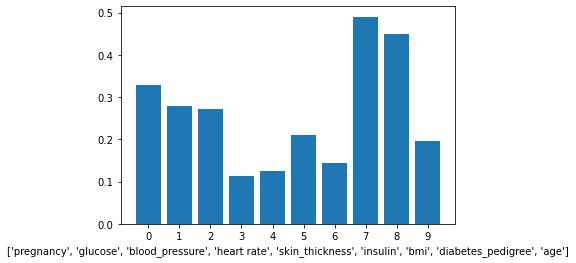

average of features for class 0 data


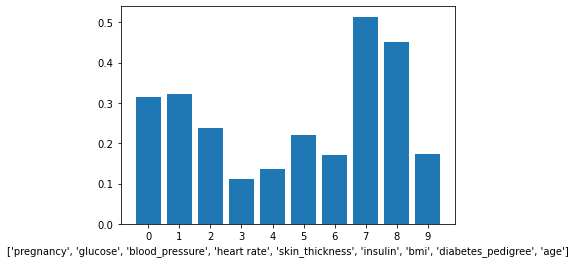

average of features for class 1 data


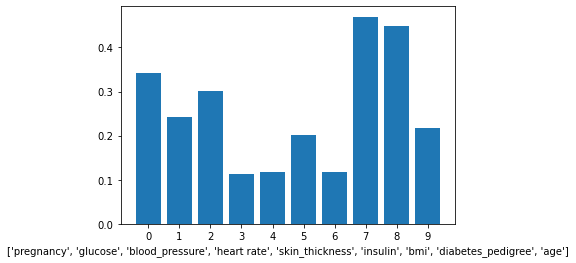

Wine dataset
average of features for all data


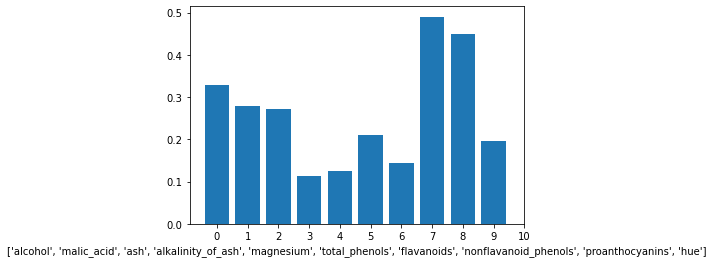

average of features for class 0 data


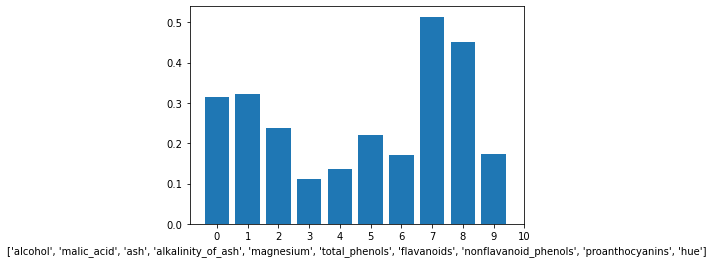

average of features for class 1 data


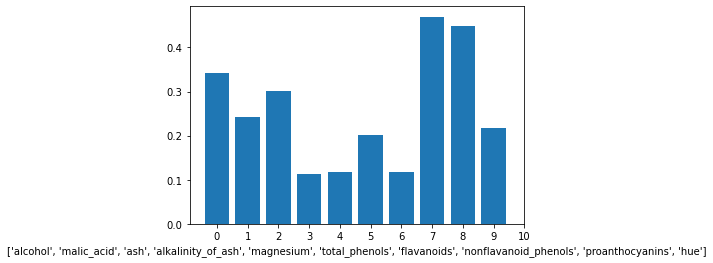

In [10]:
print("Kidney dataset")
print("average of features for all data")
features = np.arange(0,10)
plt.bar(range(len(average_of_features)), average_of_features)
plt.xticks(range(len(features)), features)
plt.xlabel(labels_k)
plt.show()

print("average of features for class 0 data")
features = np.arange(0,10)
plt.bar(range(len(average_of_class_0)), average_of_class_0)
plt.xticks(range(len(features)), features)
plt.xlabel(labels_k)
plt.show()

print("average of features for class 1 data")
features = np.arange(0,10)
plt.bar(range(len(average_of_class_1)), average_of_class_1)
plt.xticks(range(len(features)), features)
plt.xlabel(labels_k)
plt.show()

print("Wine dataset")
print("average of features for all data")
features = np.arange(0,11)
plt.bar(range(len(average_of_features)), average_of_features)
plt.xticks(range(len(features)), features)
plt.xlabel(labels_w)
plt.show()

print("average of features for class 0 data")
features = np.arange(0,11)
plt.bar(range(len(average_of_class_0)), average_of_class_0)
plt.xticks(range(len(features)), features)
plt.xlabel(labels_w)
plt.show()

print("average of features for class 1 data")
features = np.arange(0,11)
plt.bar(range(len(average_of_class_1)), average_of_class_1)
plt.xticks(range(len(features)), features)
plt.xlabel(labels_w)
plt.show()

Standard deviation for kidney data


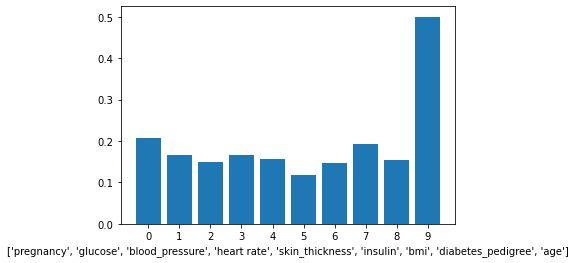

Standard deviation for wine data


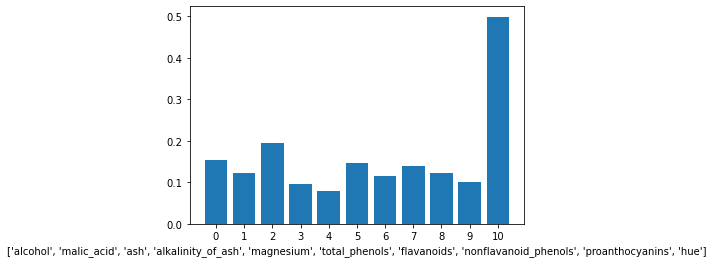

In [11]:
std = np.std(kidney_df, axis = 0)
print("Standard deviation for kidney data")
features = np.arange(0,10)
plt.bar(range(len(std)), std)
plt.xticks(range(len(features)), features)
plt.xlabel(labels_k)
plt.show()

std = np.std(wine_df, axis = 0)
print("Standard deviation for wine data")
features = np.arange(0,11)
plt.bar(range(len(std)), std)
plt.xticks(range(len(features)), features)
plt.xlabel(labels_w)
plt.show()

In [12]:
class Model:
    
    def __init__(self, data):
        np.random.seed(4)
        np.random.shuffle(data)                     #shuffle the rows
        self.full = np.asarray(data)
        self.data = data[:,:-1]                     #all columns up to last column are features data 
        self.target = data[:,-1].reshape(-1,1)      #last column is the target data convert to column vector
    
    def split_data(self, data, test_size=0.3, shuffle=False, random_state=None):
        # Shuffle data if requested
        if shuffle:
            if random_state is not None:
                np.random.seed(random_state)
            data_shuffled = np.random.shuffle(data)
        else:
            data_shuffled = data
 
        # Split data into training and testing sets
        split_index = int((1 - test_size) * data.shape[0])
        train_set = data_shuffled[:split_index]
        test_set = data_shuffled[split_index:]
        
        return train_set, test_set
    
    def add_dummy_feature(self, X):
        dummy_feature = np.ones(X.shape[0]).reshape(-1,1)
        X = np.hstack((X,dummy_feature))
        return X

    def remove_feature(self, X, feature_number = 0):
        X = np.delete(X, feature_number, axis=1)
        return X

    def sorting_by_class(self,X_training, y_training):
        data = np.hstack((X_training,y_training))
        class0 = data[data[:,9] == 0]
        class1 = data[data[:,9] == 1]
        combined = np.concatenate((class0, class1), axis=0)
        y_train = combined[:,-1].reshape(-1,1)
        X_train = combined[:,:-1]
        return X_train, y_train

    def fit_LDA(self, x_train, y_train):
        
        x,y = self.sorting_by_class(x_train,y_train)
        num_targets = np.unique(y, return_counts=True)
        N0 = num_targets[1][0]
        N1 = num_targets[1][1]
        Py0 = N0/(N1+N0)
        Py1 = N1/(N1+N0)

        mu0 = (x[y[:,0]== 0,:]).mean(0)
        mu1 = (x[y[:,0]== 1,:]).mean(0)
        mu0_r = np.tile(mu0, (N0,1))
        mu1_r = np.tile(mu1, (N1,1))
        mu = np.concatenate((mu0_r, mu1_r), axis = 0)

        sigma = (x - mu).T@(x - mu)/(N0+N1 - 2)
        sigma_inv = np.linalg.pinv(sigma)
        return Py0, Py1, mu0, mu1, sigma_inv


    def predict_LDA(self, Py0, Py1, mu0, mu1, sigma_inv, X_test, threshold=0.5):

        y_predict = []
        for i in range (X_test.shape[0] ):
          a = np.float64(math.log(Py1/Py0) - 0.5*mu1.T@sigma_inv@mu1 + 0.5*mu0.T@sigma_inv@mu0 + X_test[i].T@sigma_inv@(mu1-mu0))
          sigmoid = 1/(1+np.exp(-a))
          if sigmoid>=threshold:
            y_predict.append(1)
          else:
            y_predict.append(0)
        return y_predict


    def fit_GD(self, x_train, y_train, l_rate, error_thresh, _lambda):

        w = np.zeros(len(x_train[0]))
        y_train = y_train.flatten()
        def gradient(w):
          a = np.float64(x_train @ w)
          delta = - (y_train - 1/(1+np.exp(-a))).T@x_train + _lambda*np.sign(w)
          return delta

        counter = 0
        error = 2*error_thresh
        w_old = []
        while error >= error_thresh and counter < 10000:
          g = gradient(w)
          w_old = w
          w =  w - l_rate * g
          error = np.linalg.norm((w-w_old),2)
          counter += 1
        return w


    def predict_GD(self, x_train, w_train, threshold):

        x = np.asarray(x_train)
        w = np.asarray(w_train)
        a = x @ w
        sigmoid = 1 / (1 + np.exp(-a))
        y_predict = [int(s >=threshold) for s in sigmoid]
        return y_predict


    def accu_eval(self, y_val, y_predict):
        acc = np.asarray([int(y_val[i] == y_predict [i]) for i in range(len(y_val))])
        return acc.mean()

    def k_fold_cross(self, X_complete, y_complete, trainig_alg=0, l_rate=0.001, _lambda=0.01, threshold = 0.5):

        k=10
        accuracy_list =  []
        fold_size = int(len(X_complete)/k)
        number_examples_rounded = fold_size*k
        for i in range(0, number_examples_rounded, fold_size): 
          if(i == number_examples_rounded-fold_size):
            X_train=X_complete[:i,:]
            X_val=X_complete[i:,:]
            y_train=y_complete[:i,:]
            y_val=y_complete[i:,:]
          else:
            X_train=np.delete(X_complete, slice(i,i+fold_size),0) 
            X_val=X_complete[i:i+fold_size,:]  
            y_train=np.delete(y_complete,slice(i,i+fold_size),0)
            y_val=y_complete[i:i+fold_size,:]

          if(trainig_alg == 0):
            algorithm = "Gradient Descent"
            w_trained = self.fit_GD(X_train, y_train, l_rate, 0.001,_lambda)
            y_predict = self.predict_GD(X_val,w_trained, 0.5)
          if(trainig_alg == 1):
            algorithm = "LDA"
            Py0, Py1, mu0, mu1, sigma_inv = self.fit_LDA(X_train, y_train)
            y_predict = self.predict_LDA(Py0, Py1, mu0, mu1, sigma_inv, X_val, threshold)
          accuracy = self.accu_eval(y_val,y_predict)
          accuracy_list.append(accuracy) 
        accuracy_mean = np.mean(accuracy_list)
        return accuracy_mean, accuracy_list, algorithm


In [13]:
import copy
import time
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

def run_GD(dataset):
    model = Model(dataset) #lp_data aq_data
    x,y,z,X_complete,X_clone = [],[],[],[],[]
    best_lr = 0
    max_mean = 0
    X_clone = copy.deepcopy(model.data)
    X_complete = model.add_dummy_feature(X_clone)
    for i in range(-5,1,1):
        l_rate = 10**i
        mean, by_fold, algorithm_used = model.k_fold_cross(X_complete, model.target, 0, l_rate)
        if(mean >= max_mean):
            best_lr = l_rate
            max_mean = mean
        x.append(l_rate)
        y.append(mean)

    print("l_rate ", x)
    plt.plot(x,y)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.show()
    print("Best learning rate:", best_lr, ", highest accuracy", max(y))
    return best_lr, max(y)


Kidney GD
l_rate  [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]


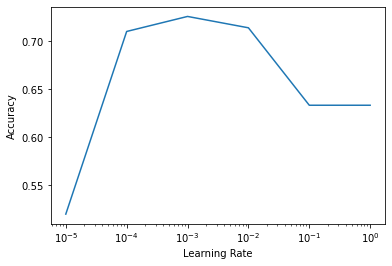

Best learning rate: 0.001 , highest accuracy 0.725609756097561
Wine GD
l_rate  [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]


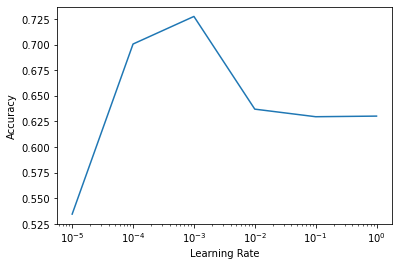

Best learning rate: 0.001 , highest accuracy 0.727439460701239


In [14]:
print("Kidney GD")
best_lr_k, gd_accuracy_k = run_GD(kidney_df) # Run gradient descent

print("Wine GD")
best_lr_w, gd_accuracy_w = run_GD(wine_df) # Run gradient descent


In [15]:
def run_LDA(dataset):
    dataset = kidney_df
    model_lda = Model(dataset) 
    x,y,z,X_complete,X_clone = [],[],[],[],[]
    t_s = np.linspace(0,1,100)
    best_threshold_LDA = 0
    max_mean = 0.0
    X_clone = copy.deepcopy(model_lda.data)
    for i in range(len(t_s)):
      threshold = t_s[i]
      start = time.time()
      mean, by_fold, algorithm_used = model_lda.k_fold_cross(X_clone, model_lda.target,1,0.001, 0.01, threshold)
      if(mean > max_mean):
        best_threshold_LDA = threshold
        max_mean = mean
      end = time.time()
      x.append(threshold)
      z.append(end-start)
      y.append(mean)

    plt.plot(x,y)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.show()

    print("Best threshold:", best_threshold_LDA, ", highest accuracy:", max(y))
    return best_threshold_LDA, max(y)

Kidney LDA


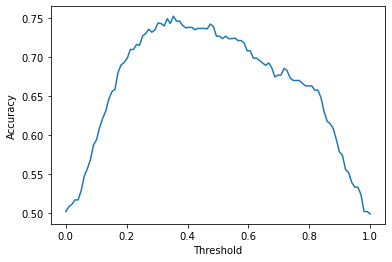

Best threshold: 0.3535353535353536 , highest accuracy: 0.7526676829268293
Wine LDA


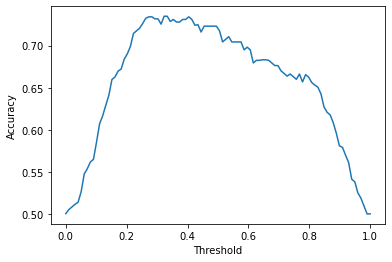

Best threshold: 0.32323232323232326 , highest accuracy: 0.734984756097561


In [16]:
print("Kidney LDA")
best_threshold_LDA_k, lda_accuracy_k = run_LDA(kidney_df)

print("Wine LDA")
best_threshold_LDA_w, lda_accuracy_w = run_LDA(wine_df)


average of accuracy for kidney data [0.725609756097561, 0.7526676829268293]


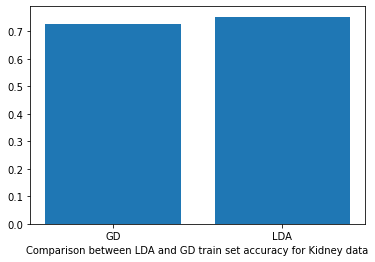

average of accuracy for wine data [0.727439460701239, 0.734984756097561]


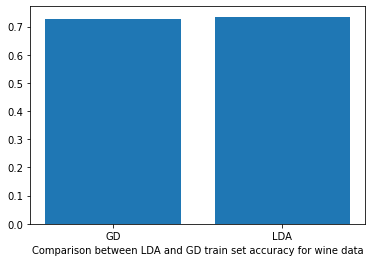

In [17]:
gd_lda1 = [gd_accuracy_k, lda_accuracy_k]
print("average of accuracy for kidney data", gd_lda1)
features = ["GD", "LDA"]
plt.bar(range(len(features)), gd_lda1)
plt.xticks(range(len(features)), features)
plt.xlabel("Comparison between LDA and GD train set accuracy for Kidney data")
plt.show()

gd_lda2 = [gd_accuracy_w, lda_accuracy_w]
print("average of accuracy for wine data", gd_lda2)
features = ["GD", "LDA"]
plt.bar(range(len(features)), gd_lda2)
plt.xticks(range(len(features)), features)
plt.xlabel("Comparison between LDA and GD train set accuracy for wine data")
plt.show()



(329, 10)


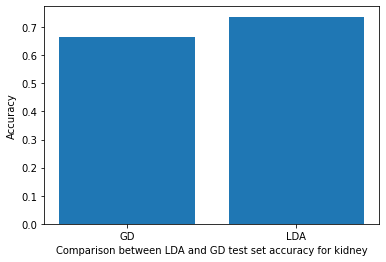

test accuracy: [0.6666666666666666, 0.7373737373737373]
train accuracy: [0.7695652173913043, 0.7608695652173914]
(329, 10)


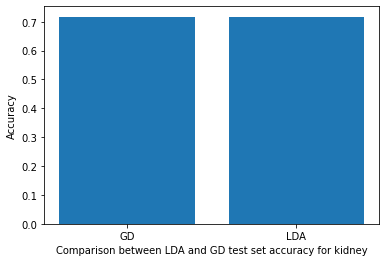

test accuracy: [0.7171717171717171, 0.7171717171717171]
train accuracy: [0.7347826086956522, 0.7608695652173914]


In [18]:
x = []
y = []
z = []
y_p_tr = []
X_complete = []

t_s = np.linspace(0,1,11)

learning_alg = ""
model = Model(kidney_df)

#train and test using the GD model
X_clone = []
X_clone = copy.deepcopy(kidney_df)
print(np.shape(X_clone))
X_complete = []
train_set, test_set = model.split_data(X_clone)
x_train = train_set[:,:-1]
x_test = test_set[:,:-1]
y_train = train_set[:,-1].reshape(-1,1)
y_test = test_set[:,-1].reshape(-1,1)
x_train = model.add_dummy_feature(x_train) 
x_test = model.add_dummy_feature(x_test)  
w_trained = model.fit_GD(x_train, y_train, best_lr_k, 0.001, 0.01)
y_predict_train = model.predict_GD(x_train, w_trained, 0.5)
y_predict = model.predict_GD(x_test, w_trained, 0.5)
mean = model.accu_eval(y_test,y_predict)
mean_train = model.accu_eval(y_train,y_predict_train)
learning_alg = "GD"
x.append(learning_alg)
y.append(mean)
y_p_tr.append(mean_train)


model2 = Model(kidney_df)

#train and test using the LDA model
X_clone = []
X_clone = copy.deepcopy(kidney_df)

train_set, test_set = model2.split_data(X_clone)
x_train = train_set[:,:-1]
x_test = test_set[:,:-1]

y_train = train_set[:,-1].reshape(-1,1)
y_test = test_set[:,-1].reshape(-1,1)
Py0, Py1, mu0, mu1, sigma_inv = model2.fit_LDA(x_train, y_train)
y_predict = model2.predict_LDA(Py0, Py1, mu0, mu1, sigma_inv, x_test, best_threshold_LDA_k)
y_predict_train = model2.predict_LDA(Py0, Py1, mu0, mu1, sigma_inv, x_train, best_threshold_LDA_k)
mean = model2.accu_eval(y_test,y_predict)
mean_train = model2.accu_eval(y_train,y_predict_train)
learning_alg = "LDA"
x.append(learning_alg)
y.append(mean)
y_p_tr.append(mean_train)
  
plt.bar(x,y)
plt.xlabel("Comparison between LDA and GD test set accuracy for kidney")
plt.ylabel('Accuracy')
plt.show()
print("test accuracy:", y)
print("train accuracy:", y_p_tr)

x = []
y = []
z = []
y_p_tr = []
X_complete = []

t_s = np.linspace(0,1,11)

learning_alg = ""
model = Model(wine_df)

#train and test using the GD model
X_clone = []
X_clone = copy.deepcopy(kidney_df)
print(np.shape(X_clone))
X_complete = []
train_set, test_set = model.split_data(X_clone)
x_train = train_set[:,:-1]
x_test = test_set[:,:-1]
y_train = train_set[:,-1].reshape(-1,1)
y_test = test_set[:,-1].reshape(-1,1)
x_train = model.add_dummy_feature(x_train) 
x_test = model.add_dummy_feature(x_test)  
w_trained = model.fit_GD(x_train, y_train, best_lr_w, 0.001, 0.01)
y_predict_train = model.predict_GD(x_train, w_trained, 0.5)
y_predict = model.predict_GD(x_test, w_trained, 0.5)
mean = model.accu_eval(y_test,y_predict)
mean_train = model.accu_eval(y_train,y_predict_train)
learning_alg = "GD"
x.append(learning_alg)
y.append(mean)
y_p_tr.append(mean_train)


model3 = Model(wine_df)

#train and test using the LDA model
X_clone = []
X_clone = copy.deepcopy(kidney_df)

train_set, test_set = model2.split_data(X_clone)
x_train = train_set[:,:-1]
x_test = test_set[:,:-1]

y_train = train_set[:,-1].reshape(-1,1)
y_test = test_set[:,-1].reshape(-1,1)
Py0, Py1, mu0, mu1, sigma_inv = model2.fit_LDA(x_train, y_train)
y_predict = model2.predict_LDA(Py0, Py1, mu0, mu1, sigma_inv, x_test, best_threshold_LDA_w)
y_predict_train = model2.predict_LDA(Py0, Py1, mu0, mu1, sigma_inv, x_train, best_threshold_LDA_w)
mean = model2.accu_eval(y_test,y_predict)
mean_train = model2.accu_eval(y_train,y_predict_train)
learning_alg = "LDA"
x.append(learning_alg)
y.append(mean)
y_p_tr.append(mean_train)
  
plt.bar(x,y)
plt.xlabel("Comparison between LDA and GD test set accuracy for kidney")
plt.ylabel('Accuracy')
plt.show()
print("test accuracy:", y)
print("train accuracy:", y_p_tr)